In [1]:
%matplotlib inline


# Multiway Cluster Robust DML

This example shows how the multiway cluster roboust DML (Chiang et al. 2020) can be implemented with the DoubleML
package.
Chiang et al. (2020) consider double-indexed data

\begin{equation}
\lbrace W_{ij}: i \in \lbrace 1, \ldots, N \rbrace, j \in \lbrace 1, \ldots, M \rbrace \rbrace
\end{equation}

and the partially linear IV regression model (PLIV)

$$\begin{aligned}
Y_{ij} = D_{ij} \theta_0 +  g_0(X_{ij}) + \epsilon_{ij}, & &\mathbb{E}(\epsilon_{ij} | X_{ij}, Z_{ij}) = 0, \\
Z_{ij} = m_0(X_{ij}) + v_{ij}, & &\mathbb{E}(v_{ij} | X_{ij}) = 0.
\end{aligned}$$

TODO: Add a few more details and the reference!
https://arxiv.org/pdf/1909.03489.pdf


In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

from sklearn.model_selection import KFold, RepeatedKFold
from sklearn.base import clone

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

from doubleml import DoubleMLData, DoubleMLPLIV
from doubleml.double_ml_resampling import DoubleMLMultiwayResampling

from doubleml.datasets import make_pliv_multiway_cluster_CKMS2019

## Simulate multiway cluster data

We use the PLIV data generating process described in Section 4.1 of Chiang et al. (2020).



In [3]:
# Set the simulation parameters
N = 25  # number of observations (first dimension)
M = 25  # number of observations (second dimension)
dim_X = 100  # dimension of X

obj_dml_data = make_pliv_multiway_cluster_CKMS2019(N, M, dim_X)

In [4]:
# The data comes with multi index for rows (tuples with two entries)
obj_dml_data.data.head(30)

X1        X2        X3        X4        X5        X6        X7  \
0 0   0.037401  0.248132  0.134533  0.629565 -0.578107 -0.314431 -0.022294   
  1  -0.012032  0.481987  0.830115  1.223850 -0.382380 -0.541054  0.507357   
  2  -0.023398 -0.182415 -0.152942 -0.106654 -0.813787 -0.423248  0.443556   
  3   0.305084  0.231658  0.059176  0.319902 -0.006606 -0.555519  0.262981   
  4  -0.050445  0.073616  0.868887  0.914573  0.068521  0.938574  0.288274   
  5   1.245466  0.100337  0.621319  0.648664  1.039469  0.684236  0.637236   
  6   1.029859 -0.491014 -0.145084  0.685571 -0.330915 -1.049923  0.646763   
  7  -0.254387  0.104032  1.096403  0.518571 -0.158471  0.125573  0.177646   
  8   0.214925  0.352899 -0.257283  0.345304 -0.475215  0.339883 -0.577123   
  9   1.036016  0.104244 -0.131323  0.392283  0.212184 -0.275450  0.121280   
  10 -0.797103  0.638513  0.795492  0.600883 -0.119002  0.050546  0.738325   
  11  0.068410 -0.262015  0.185433  0.689254 -0.472537  0.048556  0.690360   
  12 -0.891255 -0.870693 -0.160995  0.966281 -0.241211 -1.151588  0.127960   
  13 -0.269908  0.557917  0.061384  0.192745 -0.769652 -0.438895 -0.139621   
  14 -0.151056  0.644357  0.484346  1.087937  0.409619  0.269997 -0.517959   
  15 -0.150568  0.748194 -0.156725  1.103312  0.981760  1.140395  0.680385   
  16 -0.434396  1.003544  1.413333  0.813924 -0.124503 -0.230759  0.617062   
  17  0.200586 -0.410966  0.644848  0.639551 -0.635851 -1.116578  0.165443   
  18  0.153401 -1.029491  0.231619  0.683949 -0.015191 -0.170539 -0.244667   
  19 -0.151064 -0.117114 -0.840195 -0.151226 -1.038631  0.269787  0.190713   
  20  0.472438  0.020338 -0.131333  1.298812 -0.384027  0.126596  0.402736   
  21  0.150344  0.343333  0.223960  0.698235 -0.580025  0.485246  0.839776   
  22  0.438060  0.659709  0.068336  0.015523  0.180477 -1.108215  1.387854   
  23  0.225671  0.483220  0.323025  0.239326 -0.170717 -0.485694  0.193172   
  24 -0.458273 -0.189327 -0.702752 -0.578855 -0.331553 -0.815637 -0.175038   
1 0   0.840865  1.014219  1.030424  0.076138 -0.847767 -0.650738 -0.709185   
  1   0.133910 -0.140244 -0.552541 -0.283400 -0.427342  0.295892  0.764753   
  2   0.134953  0.436842  1.015081 -0.232388 -1.403105 -0.804433  0.499403   
  3   0.872682  1.019415  0.180847 -0.479312 -1.609305 -0.274573 -1.071040   
  4  -0.609253  1.183507  0.477032  0.539757 -0.847080 -0.010031  0.205542   

            X8        X9       X10  ...       X94       X95       X96  \
0 0   0.433565 -0.489281  0.214814  ... -0.541760 -0.340977  1.053565   
  1   0.212694  1.161275  0.030761  ...  0.224192  0.730870 -0.686566   
  2  -0.052819 -0.378810  0.326645  ...  0.518405  0.364165  0.641134   
  3  -0.322883  0.385392 -0.064670  ...  0.316731  0.054267  0.350580   
  4   0.281010 -0.074075  0.455256  ...  0.027147 -0.020403  0.739904   
  5  -0.276913  0.230106 -0.794274  ... -0.875514 -0.200643  0.266307   
  6  -0.063913  0.415517 -0.232349  ... -0.036291  0.122248  0.697797   
  7   0.233410 -0.021963 -0.869483  ... -1.012366 -0.429465  0.122155   
  8   0.364616  0.638436  0.327464  ... -0.969955  1.105613  0.405221   
  9   0.766627  0.712186  0.755657  ... -0.630461 -0.536850  1.624862   
  10 -0.629617 -0.271983 -0.288163  ... -0.909378  0.647282  0.839076   
  11 -0.068455  0.489322  0.814226  ... -0.601149  0.237491  0.656261   
  12  0.543124 -0.035100  0.267473  ... -0.547587  0.120127  0.229440   
  13  0.231298  0.016807  0.581185  ...  0.405254 -0.339512  0.869943   
  14 -0.106341  0.200744  0.581472  ... -0.263149 -0.027638  0.278289   
  15  0.520960  0.575300 -0.079945  ...  0.050681  0.806481  0.414040   
  16  0.319279  0.252303  0.179953  ...  0.080426  0.537100  0.171657   
  17  1.277593  0.940436  0.959930  ...  0.050951  0.307486  0.355566   
  18  0.603730  0.277275  0.013600  ...  0.692526  1.521255  0.743999   
  19 -0.168989 -0.274270 -0.457746  ... -0.060891 -0.584635 -0.442125   
  20 -0.071852  0.020590 -0.003210  ... -0.323710  0.420492 

## Initialize the objects of class DoubleMLData and DoubleMLPLIV



In [5]:
# Set machine learning methods for m & g
learner = RandomForestRegressor(max_depth=2, n_estimators=10)
ml_g = clone(learner)
ml_m = clone(learner)
ml_r = clone(learner)

# initialize the DoubleMLPLIV object
dml_pliv_obj = DoubleMLPLIV(obj_dml_data,
                            ml_g,
                            ml_m,
                            ml_r,
                            score='partialling out',
                            dml_procedure='dml1',
                            draw_sample_splitting=False)

## Split samples and transfer the sample splitting to the object



In [6]:
K = 3  # number of folds
smpl_sizes = [N, M]
obj_dml_multiway_resampling = DoubleMLMultiwayResampling(K, smpl_sizes)
smpls_multi_ind, smpls_lin_ind = obj_dml_multiway_resampling.split_samples()

dml_pliv_obj.set_sample_splitting([smpls_lin_ind])

## Fit the model and show a summary



In [7]:
dml_pliv_obj.fit()
print(dml_pliv_obj.summary)

       coef   std err          t          P>|t|     2.5 %    97.5 %
D  1.064474  0.042447  25.077544  8.744127e-139  0.981279  1.147669


## Visualization of sample splitting with tuple and linear indexing



In [8]:
#discrete color scheme
x = sns.color_palette("RdBu_r", 7)
cMap = ListedColormap([x[0], x[3], x[6]])
plt.rcParams['figure.figsize'] = 15, 12
sns.set(font_scale=1.3)

### Visualize sample splitting with tuples (one plot per fold)



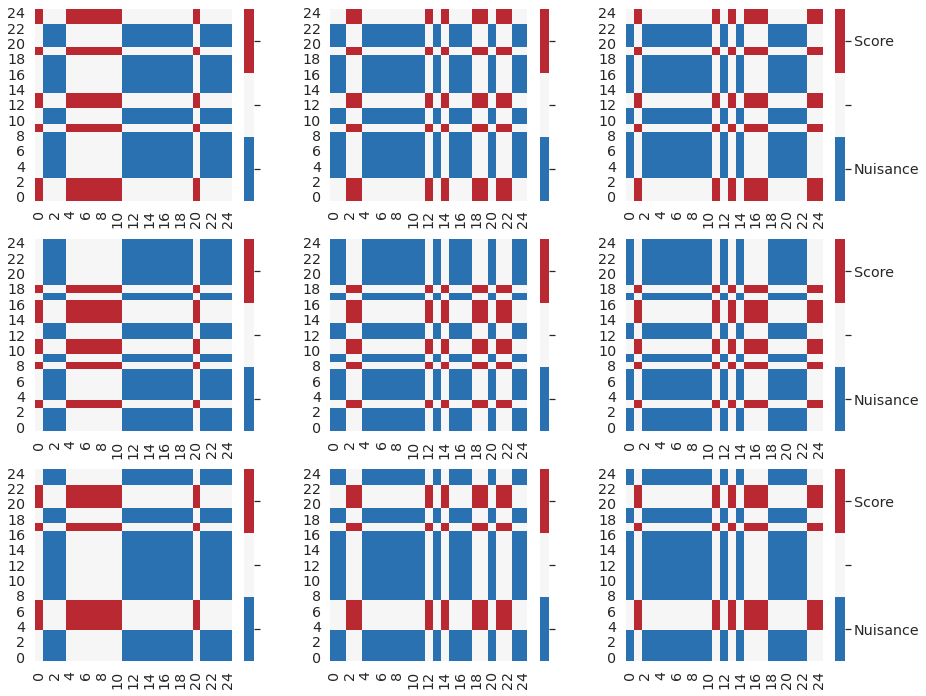

In [9]:
for i_split, this_split_ind in enumerate(smpls_multi_ind):
    plt.subplot(K, K, i_split + 1)
    df = pd.DataFrame(np.zeros([N, M]))
    ind_array_train = np.array([*this_split_ind[0]])
    ind_array_test = np.array([*this_split_ind[1]])
    df.loc[ind_array_train[:, 0], ind_array_train[:, 1]] = -1.
    df.loc[ind_array_test[:, 0], ind_array_test[:, 1]] = 1.

    ax = sns.heatmap(df, cmap=cMap);
    ax.invert_yaxis();
    ax.set_ylim([0, M]);
    colorbar = ax.collections[0].colorbar
    colorbar.set_ticks([-0.667, 0, 0.667])
    if i_split % K == (K - 1):
        colorbar.set_ticklabels(['Nuisance', '', 'Score'])
    else:
        colorbar.set_ticklabels(['', '', ''])

### Visualize sample splitting with linear indexing (one column per fold)



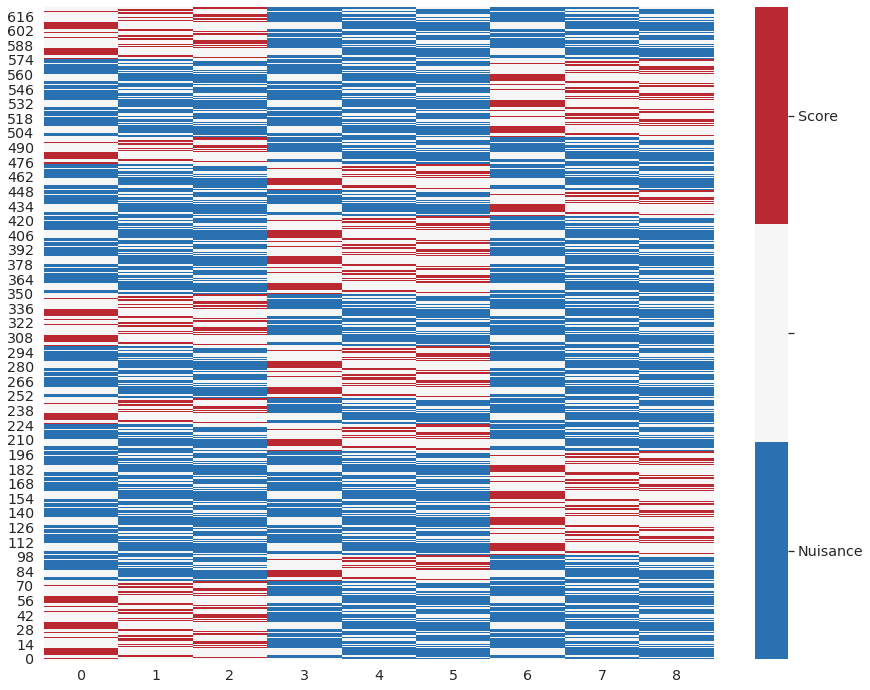

In [10]:
df = pd.DataFrame(np.zeros([N*M, K*K]))
for i_split, this_split_ind in enumerate(smpls_lin_ind):
    df.loc[this_split_ind[0], i_split] = -1.
    df.loc[this_split_ind[1], i_split] = 1.

ax = sns.heatmap(df, cmap=cMap);
ax.invert_yaxis();
ax.set_ylim([0, N*M]);
colorbar = ax.collections[0].colorbar
colorbar.set_ticks([-0.667, 0, 0.667])
colorbar.set_ticklabels(['Nuisance', '', 'Score'])